cuda:0


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 97.0MB/s]


Learning rate: 0.010000
[0,    10] loss: 6.504
[0,    20] loss: 6.264
[0,    30] loss: 5.989
[0,    40] loss: 5.797
[0,    50] loss: 5.517
[0,    60] loss: 5.245
[0,    70] loss: 4.960
[0,    80] loss: 4.695
[0,    90] loss: 4.434
[0,   100] loss: 4.228
[0,   110] loss: 4.012
[0,   120] loss: 3.835
[0,   130] loss: 3.661
[0,   140] loss: 3.483
[0,   150] loss: 3.336
Learning rate: 0.010000
[1,    10] loss: 3.100
[1,    20] loss: 2.943
[1,    30] loss: 2.879
[1,    40] loss: 2.801
[1,    50] loss: 2.666
[1,    60] loss: 2.562
[1,    70] loss: 2.484
[1,    80] loss: 2.384
[1,    90] loss: 2.323
[1,   100] loss: 2.270
[1,   110] loss: 2.193
[1,   120] loss: 2.134
[1,   130] loss: 2.037
[1,   140] loss: 2.008
[1,   150] loss: 1.985
Learning rate: 0.010000
[2,    10] loss: 1.754
[2,    20] loss: 1.740
[2,    30] loss: 1.745
[2,    40] loss: 1.706
[2,    50] loss: 1.586
[2,    60] loss: 1.599
[2,    70] loss: 1.552
[2,    80] loss: 1.566
[2,    90] loss: 1.563
[2,   100] loss: 1.488
[2,   11

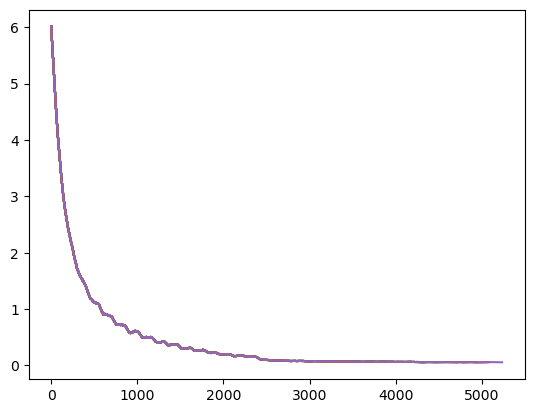

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import itertools
from torchvision.models import resnet34, ResNet34_Weights

### set up directories
prev_cpts = '/kaggle/input/bbbg_cpts/'
checkpoints = '/kaggle/working/'

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

def get_bird_data(augmentation=0, input_size=128):
    transform_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor()
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
    ])

    data_path = '/kaggle/input/birds23sp/birds/'

    trainset = torchvision.datasets.ImageFolder(root=data_path + 'train', transform=transform_train)
    testset = torchvision.datasets.ImageFolder(root=data_path + 'test', transform=transform_test)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    classes = open(data_path + "names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.90, decay=0.0005, 
          verbose=1, print_every=10, state=None, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    #optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    #adam
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='abs')

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0
        
        for g in optimizer.param_groups:
                print ("Learning rate: %f"% g['lr'])

        # Update learning rate when scheduled
#         if epoch in schedule:
#             print ("Learning rate: %f"% schedule[epoch])
#             for g in optimizer.param_groups:
#                 g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction
            

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        scheduler.step(sum_loss)
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
            plt.plot(smooth(state['losses'], 50))
            plt.savefig('checkpoint-%d.png'%(epoch+1))
    return losses

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
data = get_bird_data(input_size=256)
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', weights=ResNet34_Weights.IMAGENET1K_V1)
resnet.fc = nn.Linear(512, 555)

# selectable between starting at a checkpoint or from scratch.
if (0):
    state = torch.load(prev_cpts + 'checkpoint-15.pkl')
    resnet.load_state_dict(state['net'])
    losses = train(resnet, data['train'], epochs=20, lr=.0001, print_every=10, checkpoint_path=checkpoints, state=state)
else: 
    losses = train(resnet, data['train'], epochs=35, lr=.01, print_every=10, checkpoint_path=checkpoints)